In [16]:
#Import Files / Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#Install new libraries
!pip install spectral

In [18]:
#Import Libraries

import spectral as sp
import spectral.io.envi as envi

import numpy as np

import sklearn
import skimage

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# sns.set()

import joblib

#Set function to convert into rgb image
def to_rgb(x):
    dim = x.shape[-1]
    bands_section = int(dim/3)
    bands = [bands_section,(dim+bands_section)//2,dim-1]
    rgb = x[...,bands]
    for i in range(3):
        l,u = rgb[...,i].min(), rgb[...,i].max()
        rgb[...,i] = (rgb[...,i] - l) / (u - l)
    return np.clip(rgb,0,1)

from PIL import Image
# Example using plotly in Google Colab for interactive image viewing to select the pixels
import plotly.express as px

# Input Hyperspectral Data

In [19]:
#Input data Image 1

#Path of hdr file image1
hdrFile1='/content/drive/MyDrive/SURF/HySpectral Project/Hyperspectral-SEM Classification/hyperspectral_data_original/cropped_data/36_HYPER.hdr'

#Path of img file image1
imgFile1='/content/drive/MyDrive/SURF/HySpectral Project/Hyperspectral-SEM Classification/hyperspectral_data_original/cropped_data/36_HYPER.img'

#Open image with envi
img = envi.open(hdrFile1, imgFile1)

#Load image
hypr_c195 = img.load()

hypr_c195.shape

#Image shape
hypr_shape = hypr_c195.shape

#Set index
index = hypr_shape[-1]

#Set RGB image for plotting
img_rgb = to_rgb(hypr_c195)

#Load image
# Using Plotly to display the image
fig = px.imshow(img_rgb)
fig.show()

#Set image for rest of calculations
hypr = hypr_c195

# Input SEM data

In [20]:
#Entend maximum pixels
Image.MAX_IMAGE_PIXELS = None

# Open the PNG image using PIL
image_path = "/content/drive/MyDrive/SURF/HySpectral Project/Hyperspectral-SEM Classification/SEM_data_original/36_SEM.png"

image_pil = Image.open(image_path)

# Convert the PIL image to a NumPy array
image_np = np.array(image_pil)

#Select just the first 3 dim of the pixel rgb
image_np = image_np[:,:,:3]

# Using Plotly to display the image
fig = px.imshow(image_np)
fig.show()

## Rotate and select points of reference

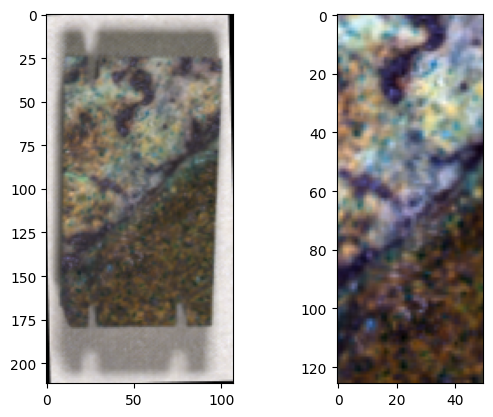

In [21]:
import cv2  # OpenCV library for image processing

#Function for rotation
def rotate_crop_image(img, pix1, pix2, pix3):
  #Calculate the angle of rotation to align the two pixels on the same x-axis location
  dy = pix2[1] - pix1[1]
  dx = pix2[0] - pix1[0]
  angle =  np.degrees(np.arctan2(dx, dy))

  #Get the image dimensions
  height, width = img.shape[:2]

  #Calculate the center
  center = (width // 2, height // 2)

  #Compute the rotation matrix
  rotation_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)
  #Perform the rotation
  rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)

  #Transform to the new pixels
  # Transform pixel coordinates
  pix1_homo = np.array([pix1[0], pix1[1], 1]).reshape(-1, 1)
  pix2_homo = np.array([pix2[0], pix2[1], 1]).reshape(-1, 1)
  pix3_homo = np.array([pix3[0], pix3[1], 1]).reshape(-1, 1)

  #Apply rotation to pixels
  n_pix1 = np.dot(rotation_matrix, pix1_homo).flatten().astype(int)
  n_pix2 = np.dot(rotation_matrix, pix2_homo).flatten().astype(int)
  n_pix3 = np.dot(rotation_matrix, pix3_homo).flatten().astype(int)

  #Crop the image
  #Modify pixel3 so it has the same y value
  n_pix3[1] = n_pix2[1]

  # Crop the image
  cropped_image = rotated_img[n_pix1[1]:n_pix2[1], n_pix1[0]:n_pix3[0]]

  return rotated_img, cropped_image

#Hyperspectral rotation/crop

#Perform the rotation (x,y)
pix1 = [27, 40]
pix2 = [24, 166]
pix3 = [74, 166]

hyper_rotated, hyper_cropped =  rotate_crop_image(hypr_c195, pix1, pix2, pix3)

#Plot rotated and cropped hyperspectral

plt.subplot(1,2,1)
plt.imshow(to_rgb(hyper_rotated))
plt.subplot(1,2,2)
plt.imshow(to_rgb(hyper_cropped))

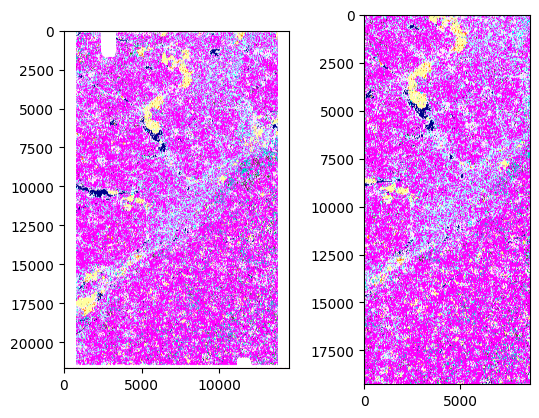

In [22]:
#SEM rotation/crop

#Perform the rotation (x,y)
pix1 = [2862,1732]
pix2 = [2862,20997]
pix3 = [11479,20997]

SEM_rotated, SEM_cropped =  rotate_crop_image(image_np, pix1, pix2, pix3)

#Plot SEM rotated and cropped
plt.subplot(1,2,1)
plt.imshow(SEM_rotated)
plt.subplot(1,2,2)
plt.imshow(SEM_cropped)

# Map data from SEM to HyperS

Take them to the same dimension?with interpolation ()
* Linear interpolation to do 1 to 1 with SEM high resolution data

**Down sample:**
* KK transform - low pass filter to small wabe numbers

**Defining size:** hyperspectral size

* Mapped matrix: Create an output array of defining size. Map here what are each of the pixelsin that cell. Number the pixels from the SEM (by columns).

* Rotate images so they are parallel to the axis
* Calculate scale factor based on saw marks.
* Define linear regression in x and y to map from SEM to hyperspectral
* Map what SEM pixel numbers are in the hyperspectral (consider SEM to hypers)



In [23]:
def map_SEM_to_hyper(SEM_img, hyper_img):
  #Flat the SEM image depending in shape:
  if len(SEM_img.shape) == 2:
    SEM_flat = SEM_cropped.flatten()
  else:
    SEM_flat = SEM_img.reshape(-1, SEM_img.shape[-1])

  #Create array of same size as hyperspectral
  SEM_content = np.zeros((hyper_img.shape[0], hyper_img.shape[1]), dtype=object)
  SEM_median = np.zeros((hyper_img.shape[0], hyper_img.shape[1],3), dtype=np.uint8)

  #Calculate Scale factor in X and Y to go from hyperspectral to SEM

  # Get the dimensions of the images
  rows_hyper, cols_hyper = hyper_img.shape[:2]
  rows_SEM, cols_SEM = SEM_img.shape[:2]

  # Calculate the scale factors
  scale_factor_rows = rows_SEM / rows_hyper
  scale_factor_cols = cols_SEM / cols_hyper

  print(SEM_img.shape)

  #Loop through all the cells in hyperspectral images
  for j in range(cols_hyper):
      # Loop through each column of pixels
      for i in range(rows_hyper):

          #convert values to SEM pixel
          si = int(i*scale_factor_rows)
          sj = int(j*scale_factor_cols)

          #convert values to next SEM pixel
          si_p = int((i+1)*scale_factor_rows)
          sj_p = int((j+1)*scale_factor_cols)


          #Create array of i and js included
          si_array = np.arange(si, si_p)
          sj_array = np.arange(sj, sj_p)

          #plot section
          #plt.imshow(image[si:si_p, sj:sj_p])
          #plt.show()

          #Create meshgrid to all possible values
          i_grid, j_grid = np.meshgrid(si_array,sj_array)

          #Flatten the grid values
          i_grid = i_grid.flatten()
          j_grid = j_grid.flatten()

          #Calculate the new indexes location
          flat_indexes = i_grid*cols_SEM + j_grid

          #print(flat_indexes)


          #Flat the selected image

          #Input the flat indexes in the array of hyper size
          SEM_content[i,j] = SEM_flat[flat_indexes]

          #Find most common color pixel in each cell

          # Find unique combinations and their counts
          colors, counts = np.unique(SEM_flat[flat_indexes], axis=0, return_counts=True)

          # Find the index of the most common combination
          median_index = np.argmax(counts)

          #print(median_index)

          #Calculate the highest value on every cell
          SEM_median[i,j] = colors[median_index]

          #print(colors[median_index])
  return SEM_content, SEM_median.astype(int)

SEM_content, SEM_median = map_SEM_to_hyper(SEM_cropped, hyper_cropped)


(19265, 8617, 3)


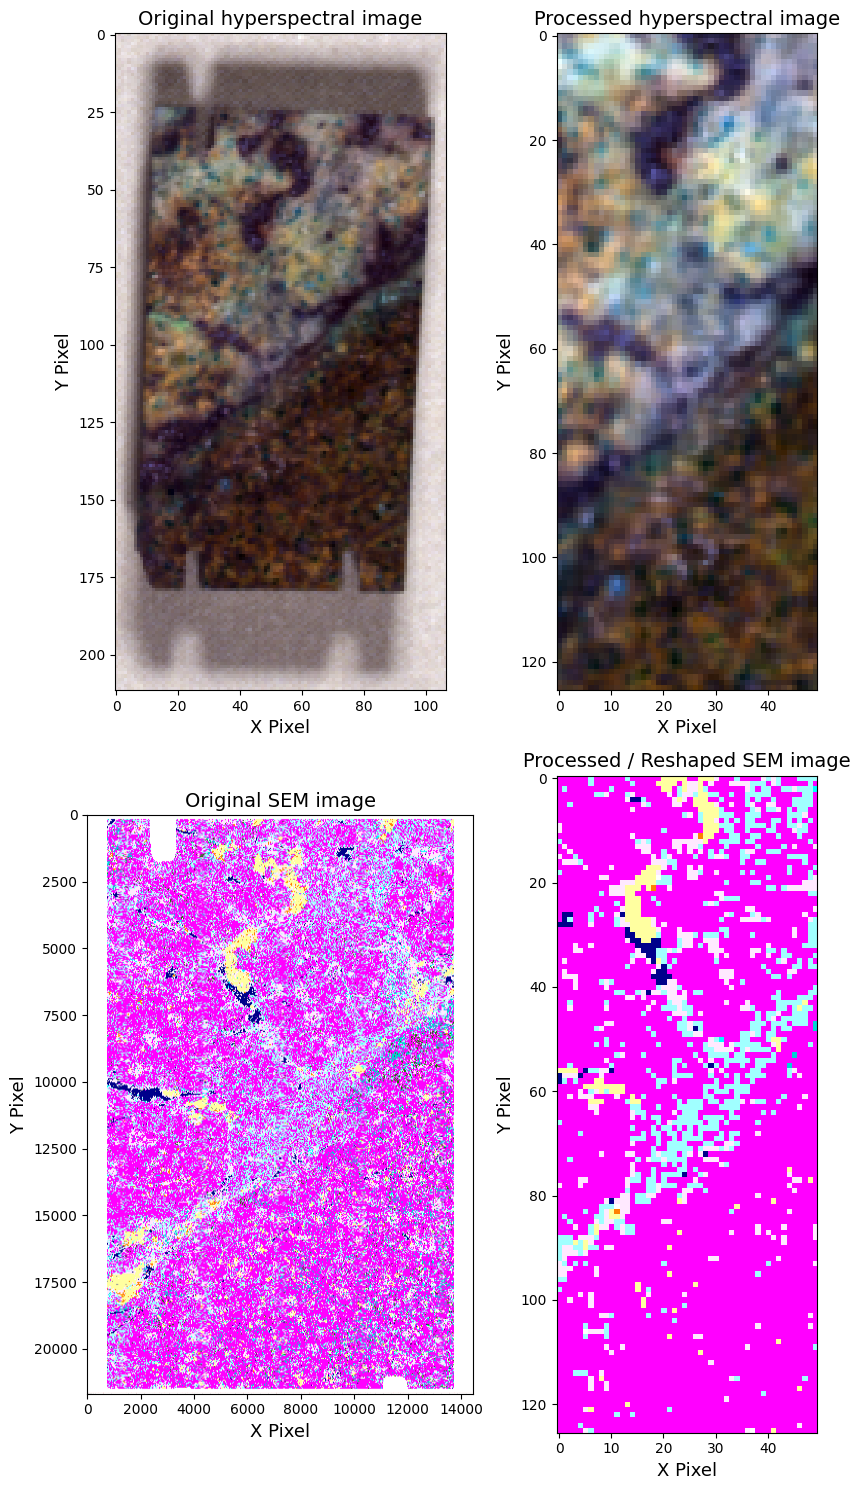

In [24]:
#print(hyper_cropped.shape, SEM_median.shape)

plt.figure(figsize=(9,15))

plt.subplot(2,2,1)
plt.imshow(img_rgb)
plt.xlabel('X Pixel', fontsize=13)
plt.ylabel('Y Pixel', fontsize=13)
plt.title("Original hyperspectral image", fontsize = 14)
plt.subplot(2,2,2)
plt.imshow(to_rgb(hyper_cropped))
plt.xlabel('X Pixel', fontsize=13)
plt.ylabel('Y Pixel', fontsize=13)
plt.title("Processed hyperspectral image", fontsize = 14)
plt.subplot(2,2,3)
plt.imshow(image_np)
plt.xlabel('X Pixel', fontsize=13)
plt.ylabel('Y Pixel', fontsize=13)
plt.title("Original SEM image", fontsize = 14)
plt.subplot(2,2,4)
plt.imshow(SEM_median)
plt.xlabel('X Pixel', fontsize=13)
plt.ylabel('Y Pixel', fontsize=13)
plt.title("Processed / Reshaped SEM image", fontsize = 14)

plt.tight_layout()
plt.show()

In [25]:
#Function to assign a label to every color
def color_classification(color_classification_dict, img):

  # Flat the image
  img_flat = img.reshape(-1, img.shape[-1])

  # Create a new array where each pixel is represented by the corresponding classification value
  image_class = np.zeros(img.shape[:-1], dtype=np.int32)
  for i in range(img.shape[0]):
      for j in range(img.shape[1]):
          pixel_color = tuple(img[i, j])
          if pixel_color in color_classification_dict:
              image_class[i, j] = color_classification_dict[pixel_color]
          else:
              image_class[i, j] = 12  # Handle unknown colors as needed

  return image_class

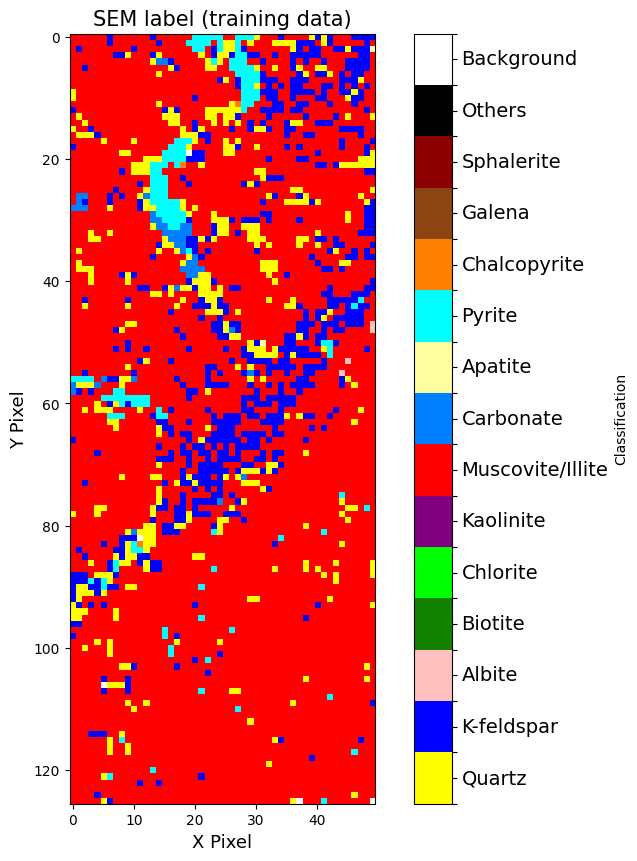

In [26]:
from matplotlib.ticker import FixedLocator

#Set tick anc color class labels:
mineral_dict = ['Quartz','K-feldspar','Albite','Biotite','Chlorite','Kaolinite','Muscovite/Illite','Carbonate','Apatite','Pyrite','Chalcopyrite','Galena','Sphalerite','Others','Background']

rgb_dict = [(255, 233, 255),(160, 255, 255),(0, 212, 212),(18, 128, 0),(0, 255, 0),(128, 0, 128),(255, 0, 255),(0, 0, 139),(0, 255, 255),(255, 255, 160),(255, 128, 0),(139, 69, 19), (139, 0, 0), (150, 150, 150),(255, 255, 255)]


class_dict = np.arange(len(rgb_dict))

#Create a dictionary using a dictionary comprehension
color_to_class = {tuple(rgb_dict): class_dict for rgb_dict, class_dict in zip(rgb_dict, class_dict)}

#Classified colors differently
SEM_class = color_classification(color_to_class, SEM_median)

#Plotting parameters

rgb_dict = [
    (255, 255, 0),   # Bright Yellow
    (0, 0, 255),     # Bright Blue
    (255, 192, 192),  # Light Pink
    (18, 128, 0),     # Dark Green
    (0, 255, 0),      # Green
    (128, 0, 128),    # Purple
    (255, 0, 0),     # Bright Red
    (0, 128, 255),   # Bright Sky Blue
    (255, 255, 160),  # Light Yellow
    (0, 255, 255),    # Cyan
    (255, 128, 0),    # Orange
    (139, 69, 19),    # Saddle Brown
    (139, 0, 0),      # Dark Red
    (0, 0, 0),  # Dim Gray
    (255, 255, 255)   # White
]

# Create a discrete colormap
cmap = ListedColormap(np.array(rgb_dict)/255.0)

#set ticks location
# Set the tick locations to be in the middle of each class interval, Make an array 2x+1
mineral_dict2 = []

for i, val in enumerate(mineral_dict):
    mineral_dict2.append(" ")
    mineral_dict2.append(val)
mineral_dict2.append(" ")


rgb_dict2 = [value for val in rgb_dict for value in [val] * 2]


#Create a dictionary using a dictionary comprehension
cmap2 = ListedColormap(np.array(rgb_dict2)/255.0)


tick_locations = np.arange(0,len(mineral_dict)+0.5,0.5)

#Set new category for plotting:
SEM_class2 = np.copy(SEM_class)
SEM_class2[-1,-1] = 15

plt.figure(figsize=(10,10))
plt.imshow(SEM_class2, cmap = cmap)
plt.xlabel('X Pixel', fontsize=13)
plt.ylabel('Y Pixel', fontsize=13)
plt.title("SEM label (training data)", fontsize=15)
cbar = plt.colorbar(ticks=tick_locations, label='Classification')
cbar.ax.tick_params(pad=3)
cbar.ax.set_yticklabels(mineral_dict2, va='center')
cbar.ax.tick_params(labelsize=14)


In [27]:
print(color_to_class)
print(mineral_dict)

{(255, 233, 255): 0, (160, 255, 255): 1, (0, 212, 212): 2, (18, 128, 0): 3, (0, 255, 0): 4, (128, 0, 128): 5, (255, 0, 255): 6, (0, 0, 139): 7, (0, 255, 255): 8, (255, 255, 160): 9, (255, 128, 0): 10, (139, 69, 19): 11, (139, 0, 0): 12, (150, 150, 150): 13, (255, 255, 255): 14}
['Quartz', 'K-feldspar', 'Albite', 'Biotite', 'Chlorite', 'Kaolinite', 'Muscovite/Illite', 'Carbonate', 'Apatite', 'Pyrite', 'Chalcopyrite', 'Galena', 'Sphalerite', 'Others', 'Background']


# Save new cropped images

In [28]:
# Save the arrays
file_SEM = "/content/drive/MyDrive/SURF/HySpectral Project/Hyperspectral-SEM Classification/SEM-hyper_training_data/36_SEM.npy"
np.save(file_SEM, SEM_class)  # Save the array with shape (125, 51, 288)

file_hyper = "/content/drive/MyDrive/SURF/HySpectral Project/Hyperspectral-SEM Classification/SEM-hyper_training_data/36_HYPER.npy"
np.save(file_hyper, hyper_cropped)  # Save the array with shape (125, 51, 3)